# LANGUAGE MODELING WITH NN.TRANSFORMER AND TORCHTEXT

This notebook is based on [PyTorch Transformer Tutorial](https://pytorch.org/tutorials/beginner/transformer_tutorial.html) on training a sequence-to-sequence model that uses the nn.Transformer module.

I will try to as much notes as I can to each step in order to make the code clearer


In [1]:
! pip install torchdata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 47 kB 1.3 MB/s 
     |████████████████████████████████| 138 kB 1.9 MB/s 
     |████████████████████████████████| 127 kB 38.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
import math
from typing import Tuple

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

### Define the model

In this notebook, we train a nn.TransformerEncoder model on a language modeling task. The language modeling task is to assign a probability for the likelihood of a given word (or a sequence of words) to follow a sequence of words. A sequence of tokens are passed to the embedding layer first, followed by a positional encoding layer to account for the order of the word (see the next paragraph for more details). The `nn.TransformerEncoder` consists of multiple layers of nn.TransformerEncoderLayer. Along with the input sequence, a square attention mask is required because the self-attention layers in `nn.TransformerEncoder` are only allowed to attend the earlier positions in the sequence. For the language modeling task, any tokens on the future positions should be masked. To produce a probability distribution over output words, the output of the nn.TransformerEncoder model is passed through a linear layer followed by a log-softmax function.

#### Quick note on Embedding Layer

Since ML/DL models take numbers as input, we need to map words in the text to numbers. Now, there are various ways we can do that - 

1. `One-Hot encoding` - Assign 1 to the word of interest, 0 to the rest and create a row in the matrix. But this becomes difficult to manage once corpus increases. This approach is inefficient. A one-hot encoded vector is sparse (meaning, most indices are zero). Imagine you have 10,000 words in the vocabulary. To one-hot encode each word, you would create a vector where 99.99% of the elements are zero.
2. `Number to Word Mapping` - A second approach you might try is to encode each word using a unique number. There are 2 downsides to this approach - 
  i. The integer-encoding is arbitrary (it does not capture any relationship between words).
 ii. An integer-encoding can be challenging for a model to interpret. A linear classifier, for example, learns a single weight for each feature. Because there is no relationship between the similarity of any two words and the similarity of their encodings, this feature-weight combination is not meaningful. 

3. `Word Embeddings` - Word embeddings give us a way to use an efficient, dense representation in which similar words have a similar encoding. Importantly, you do not have to specify this encoding by hand. An embedding is a dense vector of floating point values (the length of the vector is a parameter you specify). Instead of specifying the values for the embedding manually, they are trainable parameters (weights learned by the model during training, in the same way a model learns weights for a dense layer). It is common to see word embeddings that are 8-dimensional (for small datasets), up to 1024-dimensions when working with large datasets. A higher dimensional embedding can capture fine-grained relationships between words, but takes more data to learn.

    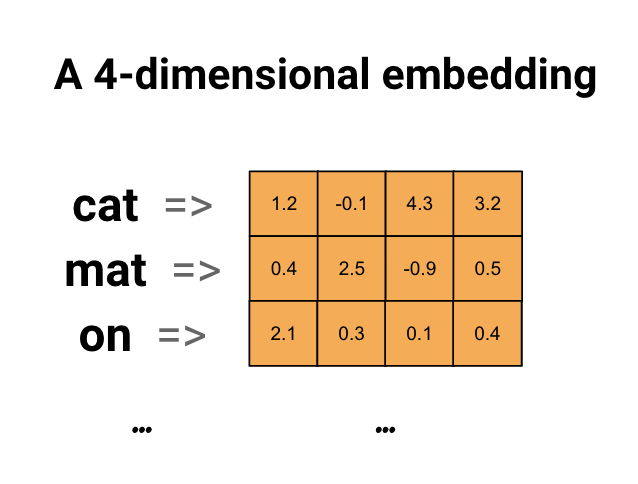

  Above is a diagram for a word embedding. Each word is represented as a 4-dimensional vector of floating point values. Another way to think of an embedding is as "lookup table". After these weights have been learned, you can encode each word by looking up the dense vector it corresponds to in the table.

In [3]:
# an Embedding module containing 10 tensors of size 3
embedding = nn.Embedding(10, 3)
# a batch of 2 samples of 4 indices each
input = torch.LongTensor([[1,2,4,5],[4,3,2,9]])
embedding(input)

tensor([[[ 0.6780, -0.1723,  0.6455],
         [ 0.3803,  0.0700,  1.6305],
         [-0.6913,  0.2721,  1.5069],
         [ 0.2090, -0.2222,  0.4772]],

        [[-0.6913,  0.2721,  1.5069],
         [ 0.2509,  0.1666, -0.6169],
         [ 0.3803,  0.0700,  1.6305],
         [-0.5486, -1.8002,  1.2772]]], grad_fn=<EmbeddingBackward0>)

We initialized a lookup table of 10 rows and 3 columns. So, every index in the input matrix got converted to a dense vector of 3 elements, with the output for a key remaining the same (see output for index = 2 or index = 4)

### Define the model

In [4]:
# Define the Transformer Model Class

# Inherit from nn.Module - Base class for all neural network modules.All PyTorch models should also subclass this class
class TransformerModel(nn.Module):

    '''
    The class takes following inputs - 
      1. ntoken - Number of Tokens. Ideally would be the size of the vocabulary
      2. d_model - the number of expected features in the input
      3. nhead - the number of heads in the multiheadattention models
      4. d_hid - 
      5. nlayers - Number of Encoder Layers
      6. DropOut - DropOut percentage
    '''

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
      
        # Init nn.Module - It's the superclass for the TransformerModel
        super().__init__()
        # Define Model Type - Purely for reference
        self.model_type = 'Transformer'
        # Positional Encoder - To be explained later
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        # Initiate TransformerEncoderLayer - Standard encoder layer. TransformerEncoderLayer is made up of self-attn and feedforward network.
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        # Create a stack of encoder layers - TransformerEncoder is a stack of N encoder layers
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        # Create Embedding Layer - initialized with number of tokens (size of the dictionary of embeddings) 
        # and number of features expected in the input - so that the embedded output have the same length
        self.encoder = nn.Embedding(ntoken, d_model)
        # Assign value to the variable - number of features expected as input
        self.d_model = d_model
        # Define Decoder model - Applies a linear transformation to the incoming data: y=xA.T +b
        self.decoder = nn.Linear(d_model, ntoken)
        # Initialize weights
        self.init_weights()


    def init_weights(self) -> None:
        "Initialize weights for encoder and decoder"
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    
    def forward(self, src: Tensor, src_mask: Tensor) -> Tensor:
        """
        Defines 1 iteration of forward propogation
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """

        # Encode the input. Multiplication is a bit ambiguous and the explanation can be found here - https://datascience.stackexchange.com/a/87909
        src = self.encoder(src) * math.sqrt(self.d_model)
        # Add positional encoding
        src = self.pos_encoder(src)
        # Pass the input to encoder
        output = self.transformer_encoder(src, src_mask)
        # Pass encoder output to decoder
        output = self.decoder(output)
        return output

def generate_square_subsequent_mask(sz: int) -> Tensor:
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

#### Positional Encoding

`PositionalEncoding` module injects some information about the relative or absolute position of the tokens in the sequence. The positional encodings have the same dimension as the embeddings so that the two can be summed. Here, we use sine and cosine functions of different frequencies.

In [5]:
class PositionalEncoding(nn.Module):
    '''
    Note that this is also a subclass of nn Module. 
    '''

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

### Load and batch data

This tutorial uses torchtext to generate Wikitext-2 dataset.

The vocab object is built based on the train dataset and is used to numericalize tokens into tensors. Wikitext-2 represents rare tokens as `<unk>`.

In [6]:
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [7]:
# Get training split of the data
train_iter = WikiText2(split='train')